In [15]:
import numpy as np
import pandas as pd
from numpy import array
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import dice_ml


In [16]:
#process data
#read from csv
df=pd.read_csv('data/univariate/kenya/ken_brt_lstm.csv')
label = 'Birth Rate'
title = 'Birth Rate crude(per 1000 people)'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    60 non-null     int64  
 1   value   60 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.1 KB


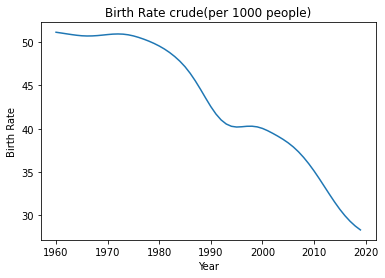

In [17]:
#visualize csv data
plt.plot(df['year'],df['value'])
plt.xlabel('Year')
plt.ylabel(label)
plt.title(title)
plt.show()

In [18]:
#separate data into training and test datasets as arrays
training_set = df.iloc[:40, 1:2].values
test_set = df.iloc[40:, 1:2].values
test_years=df.loc[43:68, 'year'].values
test_years = np.reshape(test_years, (17,1))

#normalize the data? not used yet.....
scaler = MinMaxScaler(feature_range = (0,1))
scaled_train_samples = scaler.fit_transform(training_set.reshape(-1,1))

#timesteps
n_steps = 3 

#features
n_features = 1


In [19]:
#split the data set into time steps that predict the next step: X for samples, y for labels (actual output)

def split_sequence(sequence, n_steps):
    print(len(sequence))
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [20]:
#prepare the data for training
#split into samples and labels
x, y = split_sequence(training_set, n_steps)
x.shape

40


(37, 3, 1)

In [21]:
#build the model
#activation: relu to get the max btwn 0 and the input, default activation on the output layer (sigmoid), Dense on output

model = Sequential([
    LSTM(units=50, input_shape=(n_steps, n_features), activation='relu',return_sequences=True),
    LSTM(50, activation='relu',return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(units=1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
#compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss='mse', 
    metrics=['accuracy']
)

In [23]:
#train the model
model.fit(
    x, 
    y, 
    batch_size=1, 
    validation_split=0.1,
    epochs=100, 
    verbose=2
)

Epoch 1/100
33/33 - 2s - loss: 414.0503 - accuracy: 0.0000e+00 - val_loss: 4.3305 - val_accuracy: 0.0000e+00
Epoch 2/100
33/33 - 0s - loss: 9.5770 - accuracy: 0.0000e+00 - val_loss: 1.9690 - val_accuracy: 0.0000e+00
Epoch 3/100
33/33 - 0s - loss: 1.1840 - accuracy: 0.0000e+00 - val_loss: 0.9177 - val_accuracy: 0.0000e+00
Epoch 4/100
33/33 - 0s - loss: 0.8934 - accuracy: 0.0000e+00 - val_loss: 1.0843 - val_accuracy: 0.0000e+00
Epoch 5/100
33/33 - 0s - loss: 1.6165 - accuracy: 0.0000e+00 - val_loss: 0.5623 - val_accuracy: 0.0000e+00
Epoch 6/100
33/33 - 0s - loss: 1.4281 - accuracy: 0.0000e+00 - val_loss: 1.4783 - val_accuracy: 0.0000e+00
Epoch 7/100
33/33 - 0s - loss: 1.7538 - accuracy: 0.0000e+00 - val_loss: 0.1056 - val_accuracy: 0.0000e+00
Epoch 8/100
33/33 - 0s - loss: 1.4275 - accuracy: 0.0000e+00 - val_loss: 6.5603 - val_accuracy: 0.0000e+00
Epoch 9/100
33/33 - 0s - loss: 1.0563 - accuracy: 0.0000e+00 - val_loss: 0.0998 - val_accuracy: 0.0000e+00
Epoch 10/100
33/33 - 0s - loss: 1.3

In [24]:
#Prep the test data
x_test, y_test = split_sequence(test_set, n_steps)
x_test.shape

20


(17, 3, 1)

In [25]:
#Predict
predictions = model.predict(
    x_test,
    batch_size = 1, 
    verbose = 2
)
predictions

17/17 - 0s


array([[38.216248],
       [37.909107],
       [37.558456],
       [37.177044],
       [36.753468],
       [36.267483],
       [35.697025],
       [35.029816],
       [34.26282 ],
       [33.403572],
       [32.462273],
       [31.459738],
       [30.42837 ],
       [29.404345],
       [28.42127 ],
       [27.514523],
       [26.709404]], dtype=float32)

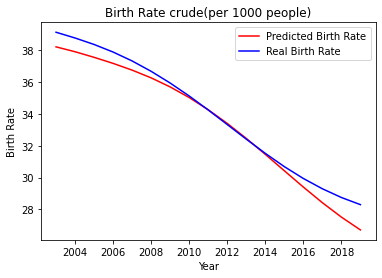

In [26]:
# Visualising the results

plt.plot(test_years,predictions, color = 'red', label = 'Predicted Birth Rate')
plt.plot(test_years,y_test, color = 'blue', label = 'Real Birth Rate')
plt.legend()
# plt.xticks(np.arange(0,2,8))
plt.xlabel('Year')
plt.ylabel(label)
plt.title(title)
plt.show()
sns.set(rc={'figure.figsize':(8,6)})

In [27]:
test_set

array([[40.037],
       [39.777],
       [39.468],
       [39.135],
       [38.773],
       [38.366],
       [37.89 ],
       [37.33 ],
       [36.678],
       [35.942],
       [35.128],
       [34.249],
       [33.333],
       [32.415],
       [31.522],
       [30.688],
       [29.943],
       [29.296],
       [28.748],
       [28.298]])

            -------------Counterfactual Analysis using Dice-------------

In [29]:
# supress deprecation warnings from TF
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

backend = 'TF'+tf.__version__[0]  # TF1
# ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
# Step 2: dice_ml.Model
m = dice_ml.Model(model_path=model, backend=backend)


In [ ]:
# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=df, continuous_features=['age', 'hours_per_week'], outcome_name='income')